# ffp

> A module to model and calculate the properties of Free Floating Planets (FFPs), such as density, mass, distance, and velocity distribution.

In [ ]:
#| default_exp ffp

In [ ]:
#| hide
from nbdev.showdoc import *

In [ ]:
#| export
from LensCalcPy.parameters import *
from LensCalcPy.utils import *
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import nquad



In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
#| export
class Ffp:
    pass
    

In [ ]:
get_primed_coords(1)

(6.682548931412759, 3.4049287480466006)

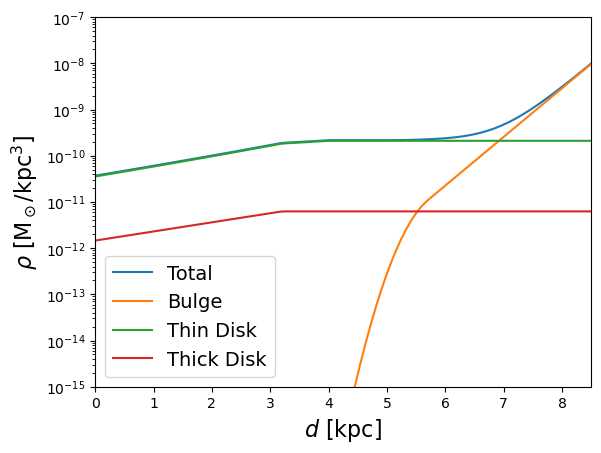

In [ ]:
# Define values for the x-axis
d = np.linspace(0, rEarth, num=100)
z = 0
# Calculate the density values for each component
rho_total_arr = [rho_FFPs(i) for i in d]
rho_bulge_arr = [rho_bulge(i) for i in d]
rho_thin_arr = [rho_thin(dist_mw(i), z) for i in d]
rho_thick_arr = [rho_thick(dist_mw(i), z) for i in d]

# Create the log plot
plt.plot(d, rho_total_arr, label="Total")
plt.plot(d, rho_bulge_arr, label="Bulge")
plt.plot(d, rho_thin_arr, label="Thin Disk")
plt.plot(d, rho_thick_arr, label="Thick Disk")

# Add labels and legend
plt.xlabel(r"$d$ [kpc]", fontsize=16)
plt.ylabel(r"$\rho$ [M$_\odot$/$\mathrm{kpc}^3$]", fontsize=16)
plt.legend(fontsize=14)

plt.yscale("log")
plt.xlim(0, rEarth)
plt.ylim(1e-15, 1e-7)

# Show the plot
plt.show()


In [ ]:
#| export
options = {"epsabs": 1e-10, "epsrel": 1e-10}

def dGdt_FFP(t, mFFP):
    def integrand(umin, d):
        return 1 / (ut**2 - umin**2)**(1/2) * rho_FFPs(d) / \
               (mFFP * velocity_dispersion(d)**2) * velocity_radial(d, mFFP, umin, t * htosec)**4 * \
               (htosec / kpctokm)**2 * np.exp(-velocity_radial(d, mFFP, umin, t * htosec)**2 / velocity_dispersion(d)**2)
    result, _ = nquad(integrand, [(0, ut), (0, rEarth)], opts=options)
    return 2 * result

In [ ]:
mFFP = 1e-3
t = np.logspace(0, 4, num=100)
ffp_diff_rates = [dGdt_FFP(i, mFFP) for i in t]

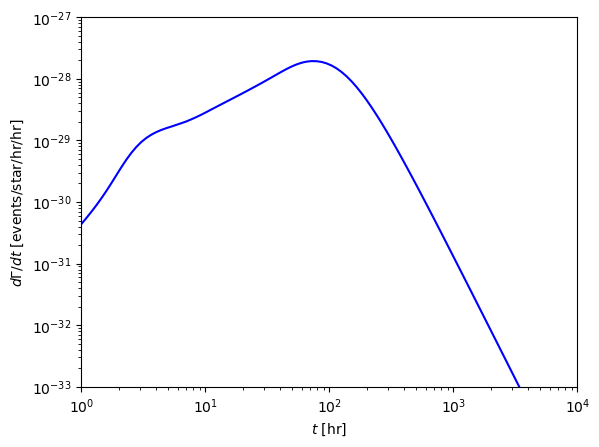

In [ ]:
plt.loglog(t, ffp_diff_rates, 
           label="Event Rate", color="blue")
plt.xlabel(r"$t$ [hr]")
plt.ylabel(r"$d\Gamma/dt$ [events/star/hr/hr]")
plt.xscale("log")
plt.yscale("log")
plt.xlim(1e0, 1e4)
plt.ylim(1e-33, 1e-27)
plt.show()


## Perform Weighted Sum over FFP distribution

In [ ]:
#Todo: will want to fold this into the FFP class eventually
mMin = 1e-5  # solar masses
mMax = 1e-2
alpha = 2
nFFPs = 1e4
nBins = 10
tMin = 1e-2  # hours
tMax = 1e3
ntBins = 10

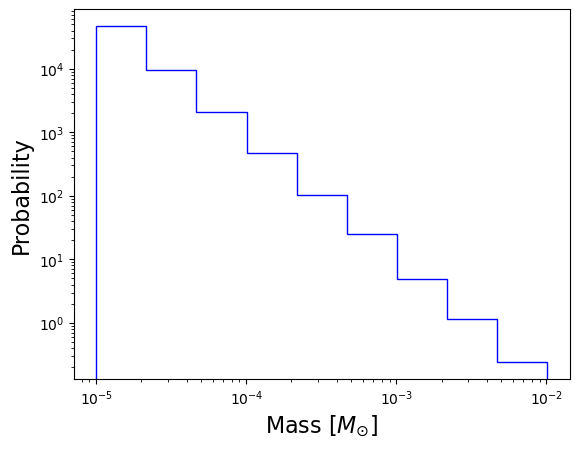

In [ ]:
mSample = mMin * (1 - np.random.rand(int(nFFPs)))**(-1 / (alpha - 1))
tBins = np.logspace(np.log10(tMin), np.log10(tMax), num=ntBins)
bins = np.logspace(np.log10(mMin), np.log10(mMax * 1.01), num=nBins)
hist, bins = np.histogram(mSample, bins=bins, density=True)

plt.hist(mSample, bins=bins, density=True, histtype="step", color="blue")

plt.xlabel("Mass [$M_{\odot}$]", fontsize=16)
plt.ylabel("Probability", fontsize=16)
plt.xscale("log")
plt.yscale("log")
plt.show()

In [ ]:
counts, hist_bins, = np.histogram(mSample, bins=bins, density=True)
bin_centers = (hist_bins[1:] + hist_bins[:-1]) / 2
ffpPDF = np.zeros((len(counts), len(bin_centers)))
ffpPDF[0] = counts/np.sum(counts)
ffpPDF[1] = bin_centers

In [ ]:
from scipy.interpolate import interp1d

tETable = np.zeros((len(ffpPDF[0])-1, len(tBins)))
for i in range(len(ffpPDF[0])-1):
    for j in range(len(tBins)):
        tETable[i,j] = ffpPDF[0][i] * dGdt_FFP(tBins[j], ffpPDF[1][i])

In [ ]:
tEWeighted = np.sum(tETable, axis=0)
tEInterp = interp1d(np.log10(tBins), np.log10(tEWeighted), kind="cubic")

In [ ]:
t = np.logspace(-2, np.log10(5e1), num=100)
weighted_rate = 10**tEInterp(np.log10(t))

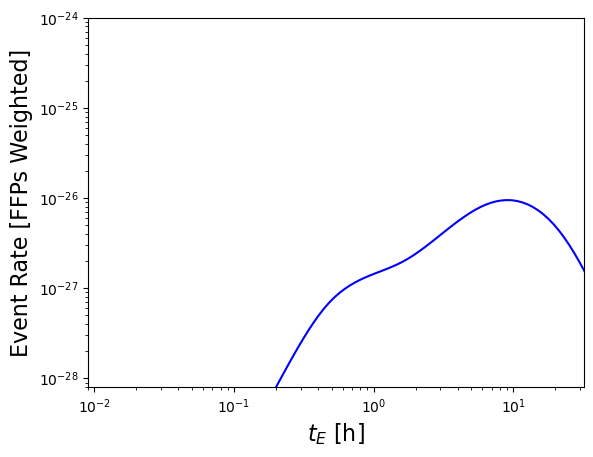

In [ ]:
plt.loglog(t, weighted_rate, color="blue")
plt.xlabel(r"$t_E$ [h]", fontsize=16)
plt.ylabel("Event Rate [FFPs Weighted]", fontsize=16)
plt.xlim([0.009, 32])
plt.ylim([8e-29, 1e-24])
plt.show()


In [ ]:
#| export
def foo(): pass

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()